# Top2Vec experiment to find best embedding model and number of topics
based on 1st starting posts in "Hotline" Russian women forum eva.ru

In [ ]:
!pip install top2vec[sentence_encoders]
#!pip install top2vec[sentence_transformers] breaks plotly.express

In [ ]:
#!pip install plotly==5.5.0

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np

In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import fcluster, linkage
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
!pip install pymorphy2

In [ ]:
import pymorphy2

In [ ]:
from top2vec import Top2Vec
np.random.seed(42)

In [ ]:
import gensim.corpora as corpora
from gensim.utils import tokenize
from gensim.models import CoherenceModel

In [11]:
from wordcloud import WordCloud
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
#Saving into log (Excel file)
import openpyxl 
def SaveToExperimentLog(Experiments_file, LogEntry, data):
    book = openpyxl.load_workbook(Experiments_file)
    writer = pd.ExcelWriter(Experiments_file, engine='openpyxl') 
    writer.book = book

    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

    data.to_excel(writer, LogEntry[0:29],index=False)

    writer.save()
    writer.close()

def SaveChartToExperimentLog(Experiments_file, LogEntry, Start_Position, Step, lst_img_filenames):
    book = openpyxl.load_workbook(Experiments_file)
    ws = book[LogEntry[0:29]]
    p = Start_Position + 10
    for f in lst_img_filenames:
        img = openpyxl.drawing.image.Image(f)
        ws.add_image(img)
        position = p
        img.anchor = 'A%s'%p
        p = p + Step

    book.save(Experiments_file)    

In [ ]:
#Topics Distance map visualization
#Thanks to https://github.com/MaartenGr/BERTopic/tree/master/bertopic/plotting




def _plotly_topic_visualization(data: pd.DataFrame,
                                width: int,
                                height: int):
    """ Create plotly-based visualization of topics with a slider for topic selection """
    topic_list = data['Topic'].tolist()
    def get_color(topic_selected):
        marker_color = ['red' if topic == topic_selected else '#B0BEC5' for topic in topic_list]
        return [{'marker.color': [marker_color]}]

    # Prepare figure range
    x_range = (data.x.min() - abs((data.x.min()) * .15), data.x.max() + abs((data.x.max()) * .15))
    y_range = (data.y.min() - abs((data.y.min()) * .15), data.y.max() + abs((data.y.max()) * .15))

    # Plot topics
    fig = px.scatter(data, x='x', y='y', size='Size', size_max=40, template='simple_white', labels={'x': '', 'y': ''},hover_data=['Topic','Words','Size'])

    fig.update_traces(marker=dict(color='#B0BEC5', line=dict(width=2, color='DarkSlateGrey')))

    # Update hover order
    
    fig.update_traces(hovertemplate='<br>'.join(['<b>Topic %{customdata[0]}</b>',
                                                 'Words: %{customdata[1]}',
                                                 'Size: %{customdata[2]}']))

    # Create a slider for topic selection
    steps = [dict(label=f'Topic {topic}', method='update', args=get_color(topic)) for topic in topic_list]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
        title={
            'text': '<b>Topics Distance Map',
            'y': .95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color='Black')
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor='white',
            font_size=16,
            font_family='Rockwell'
        ),
        xaxis={'visible': False},
        yaxis={'visible': False},
        sliders=sliders
    )

    # Update axes ranges
    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)

    # Add grid in a 'plus' shape
    fig.add_shape(type='line',
                  x0=sum(x_range) / 2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color='#CFD8DC', width=2))
    fig.add_shape(type='line',
                  x0=x_range[0], y0=sum(y_range) / 2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color='#9E9E9E', width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text='D1', showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text='D2', showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

def topics_distance_map(model, top_n_topics = None, reduced=False,  width = 650, height = 650, topic_names: list = None):
  """ Visualize topics, their sizes, and their corresponding words
  This visualization is highly inspired by LDAvis, a great visualization
  technique typically reserved for LDA.
  Arguments:
        model: A fitted Top2Vec instance.
        top_n_topics: Only select the top n most frequent topics
        reduced: Original topics are used by default. 
                 If True the reduced topics will be used.        
        width: The width of the figure.
        height: The height of the figure.
    Usage:
    To visualize the topics simply run:
    ```python
    topic_model.visualize_topics()
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_topics()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/viz.html"
    style="width:1000px; height: 680px; border: 0px;""></iframe>
  """


  # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=top_n_topics)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

  topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)


  if reduced:
    topic_vectors=model.topic_vectors_reduced
  else:
    topic_vectors=model.topic_vectors

  if topic_names:
    words = topic_names
  else:
    words = ['_'.join([word for word in x[:3]]) for x in topic_words]

  #topics vectors into 2D via cosine similarity 
  embeddings = MinMaxScaler().fit_transform(topic_vectors)
  embeddings = UMAP(n_neighbors=2, n_components=2,metric='cosine',random_state=42).fit_transform(embeddings)

  data = pd.DataFrame({'x': embeddings[0:, 0], 'y': embeddings[0:, 1], 'Topic': topic_nums, 'Words': words, 'Size': topic_sizes})
  if top_n_topics is not None:
    data=data.head(top_n_topics)
  return _plotly_topic_visualization(data, width, height)

In [ ]:
#heatmap of the topic's similarity matrix
#Thanks to https://github.com/MaartenGr/BERTopic/tree/master/bertopic/plotting

def visualize_heatmap(model,
                      top_n_topics: int = None,
                      n_clusters: int = None,
                      reduced=False,
                      width: int = 800,
                      height: int = 800,
                      topic_names: list = None) -> go.Figure:
    """ Visualize a heatmap of the topic's similarity matrix
    Based on the cosine similarity matrix between topic embeddings,
    a heatmap is created showing the similarity between topics.
    Arguments:
        model: A fitted Top2Vec instance.
        top_n_topics: Only select the top n most frequent topics.
        n_clusters: Create n clusters and order the similarity
                    matrix by those clusters.
        reduced: Original topics are used by default. 
                 If True the reduced topics will be used.
        width: The width of the figure.
        height: The height of the figure.
    Returns:
        fig: A plotly figure
    Usage:
    To visualize the similarity matrix of
    topics simply run:
    ```python
    topic_model.visualize_heatmap()
    ```
    Or if you want to save the resulting figure:
    ```python
    fig = topic_model.visualize_heatmap()
    fig.write_html("path/to/file.html")
    ```
    <iframe src="../../getting_started/visualization/heatmap.html"
    style="width:1000px; height: 720px; border: 0px;""></iframe>
    """

    # Extract topic words, sizes and embeddings
    if ((model.topic_vectors_reduced is None) & (reduced)):
      topic_mapping = model.hierarchical_topic_reduction(num_topics=top_n_topics)

    topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
    topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

    if reduced:
      topic_vectors=model.topic_vectors_reduced
    else:
      topic_vectors=model.topic_vectors


    if top_n_topics is not None:
      embeddings = topic_vectors[0:top_n_topics]
      topics=topic_nums[0:top_n_topics]
    else:
      embeddings = topic_vectors
      topics=topic_nums


    # Order heatmap by similar clusters of topics
    if n_clusters:
        if n_clusters >= len(topics):
            raise ValueError("Make sure to set `n_clusters` lower than "
                             "the total number of unique topics.")

        #embeddings = embeddings[[topic + 1 for topic in topics]]
        distance_matrix = cosine_similarity(embeddings)
        Z = linkage(distance_matrix, 'ward')
        clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

        # Extract new order of topics
        mapping = {cluster: [] for cluster in clusters}
        for topic, cluster in zip(topics, clusters):
            mapping[cluster].append(topic)
        mapping = [cluster for cluster in mapping.values()]
        sorted_topics = [topic for cluster in mapping for topic in cluster]
    else:
        sorted_topics = topics

    # Select embeddings
    indices = np.array([topics[topic] for topic in sorted_topics])
    embeddings = embeddings[indices]
    distance_matrix = cosine_similarity(embeddings)

    # Create nicer labels
    if topic_names:
      new_labels = topic_names
    else:
      new_labels = [[str(topic)]+ topic_words[topic] for topic in sorted_topics]
      new_labels = ["_".join([label for label in labels[:4]]) for labels in new_labels]
      new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    fig = px.imshow(distance_matrix,
                    labels=dict(color="Similarity Score"),
                    x=new_labels,
                    y=new_labels,
                    color_continuous_scale='GnBu'
                    )

    fig.update_layout(
        title={
            'text': "<b>Similarity Matrix",
            'y': .95,
            'x': 0.55,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=22,
                color="Black")
        },
        width=width,
        height=height,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell"
        ),
    )
    fig.update_layout(showlegend=True)
    fig.update_layout(legend_title_text='Trend')
    return fig

In [3]:
#Topics Size WordMap
def topics_size_word_map(topic_size_dic, mask_image_file=None, width=1600, height=800, width_figsize=20, height_figsize=10):
  if mask_image_file:
    img_mask = np.array(Image.open(mask_image_file))
  else:
    img_mask = None
  wc = WordCloud(background_color="white", max_words=1000, mask=img_mask, width=width, height=height)
    
  #generate word cloud
  wc.generate_from_frequencies(topic_size_dic)

  # show
  plt.figure( figsize=(width_figsize,height_figsize) )
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()

  return wc

In [ ]:
#Topics content wordmap
def topics_content_word_map(model,reduced=False, nrows=5, ncols=2,  width=1000, height=1000, width_figsize=10, height_figsize=20, topic_content: list = None, topic_names: list = None):

   # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=nrows*ncols)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_sizes, topic_nums = model.get_topic_sizes(reduced=reduced)
  if topic_content:
    topic_words=topic_content
  else:
    topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]


  fig, axs = plt.subplots(nrows,ncols, figsize=(width_figsize, height_figsize))

  fig.tight_layout()

  axs = axs.ravel()
  for idx,t in enumerate(topic_nums):
    if idx>nrows*ncols-1:
      break
    wordmap_dict = dict(zip(topic_words[idx], word_scores[idx]))
    if topic_names:
      Title = '%s (%s)'%(topic_names[idx],topic_sizes[idx])
    else:
      Title = 'Topic %s (%s)'%(t,topic_sizes[idx])

    wc = WordCloud(background_color="white", max_words=1000, width=width, height=height)
    wc.generate_from_frequencies(wordmap_dict)
    axs[idx].imshow(wc)
    axs[idx].axis('off')
    axs[idx].title.set_text(Title)

  return fig

In [ ]:
#Topics data in a form of pandas data frame
#lemmanization - normal form for topic name
morph = pymorphy2.MorphAnalyzer()
def lemmanized_first_word(text):
    words = text.split(',') # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)
        res.append(p[0].normal_form)
        
    return  set(res[0:1]).pop()
def topic_name(row):
    text = row['Words']        
    return  lemmanized_first_word(text)

def TopicsData (model):
  # model: A fitted Top2Vec instance.

  topic_words, word_scores,topic_nums = model.get_topics()
  topic_sizes, topic_nums = model.get_topic_sizes()
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]
  topics_df=pd.DataFrame({'Id':topic_nums.tolist(),
              'Size':topic_sizes.tolist(),
              'Words':[','.join(x) for x in topic_words],
              'Scores':word_scores.tolist()
              })
  topics_df['Name'] = topics_df.apply(topic_name,axis=1)

  return topics_df

def ReducedTopicsData (model,num_topics=15):
  # model: A fitted Top2Vec instance

  # Extract topic words, sizes etc
  topic_mapping = model.hierarchical_topic_reduction(num_topics=num_topics)


  topic_words_reduced, word_scores_reduced,topic_nums_reduced = model.get_topics(reduced=True)
  topic_sizes_reduced, topic_nums_reduced = model.get_topic_sizes(reduced=True)
  topic_words_reduced=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words_reduced]

  topics_reduced_df=pd.DataFrame({'Id':topic_nums_reduced.tolist(),
              'Size':topic_sizes_reduced.tolist(),
              'Words':[','.join(x) for x in topic_words_reduced],
              'Scores':word_scores_reduced.tolist(),
              'Mapping':topic_mapping
              })
  topics_reduced_df['Name'] = topics_reduced_df.apply(topic_name,axis=1)


  return topics_reduced_df
  
def Map_topics_and_reduced(topics_df, topics_reduced_df):
  d_topic_mapping={}
  for index, row in topics_reduced_df.iterrows():
    for v in row['Mapping']:
      d_topic_mapping[v]=row['Id'] 
  topics_df['Group'] = topics_df['Id'].map(d_topic_mapping)   
  topics_df = pd.merge(topics_df,reduced_topics_df[['Id','Size','Words','Scores','Name']], left_on='Group', right_on='Id', how='inner', suffixes=('', '_reduced'))
  topics_df=topics_df[['Id','Size','Words','Scores','Name','Group','Size_reduced','Words_reduced','Scores_reduced','Name_reduced']]
  topics_df.columns=['Id','Size','Words','Scores','Name','Group_Id','Size_reduced','Words_reduced','Scores_reduced','Name_reduced']
  return topics_df   

In [ ]:
#Model score - coherence

def model_coherence(model, data, reduced=False,num_topics=15):
  # model: A fitted Top2Vec instance.
  # data used in the model (list of strings)
  # reduced: Original topics are used by default. 
  #          If True the reduced topics will be used.
  # num_topics is used only if reduced=True
  
  # Extract topic words, sizes and embeddings
  if ((model.topic_vectors_reduced is None) & (reduced)):
    topic_mapping = model.hierarchical_topic_reduction(num_topics=num_topics)

  topic_words, word_scores,topic_nums = model.get_topics(reduced=reduced)
  topic_words=topic_words.tolist()
  topic_words=[[x.replace('s','й').replace('S','Й').replace('r','ё').replace('R','Ё') for x in w] for w in topic_words]

  tokenized = [s.split() for s in data]
  id2word = corpora.Dictionary(tokenized)
  corpus = [id2word.doc2bow(text) for text in tokenized]

  cm = CoherenceModel(topics=topic_words,texts=tokenized, corpus=corpus, dictionary=id2word, coherence='c_v')
  return cm.get_coherence()

In [6]:
#Experiment Set up - file names etc
Data = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Data/'

Chapter_Id=63

Images = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Images/'

#black&white image with background removed and set to white
##https://www9.lunapic.com/ can help with background
Mask_Image_filename='%s.png'%Chapter_Id
Mask_Image_full_filename=os.path.join(Images, Mask_Image_filename)

TopicsSizeWordCloud_filename = '%s_topics_size_wordcloud.png'%Chapter_Id
TopicsSizeWordCloud_full_filename=os.path.join(Images, TopicsSizeWordCloud_filename)

TopicsSizeWordCloud_filename_eng = '%s_topics_size_wordcloud_eng.png'%Chapter_Id
TopicsSizeWordCloud_full_filename_eng=os.path.join(Images, TopicsSizeWordCloud_filename_eng)

TopicsContentWordCloud_filename = '%s_topics_content_wordcloud.png'%Chapter_Id
TopicsContentWordCloud_full_filename=os.path.join(Images, TopicsContentWordCloud_filename)

TopicsContentWordCloud_filename_eng = '%s_topics_content_wordcloud_eng.png'%Chapter_Id
TopicsContentWordCloud_full_filename_eng=os.path.join(Images, TopicsContentWordCloud_filename_eng)

Heatmap_filename = '%s_heatmap.html'%Chapter_Id
Heatmap_full_filename=os.path.join(Images, Heatmap_filename)

Heatmap_filename_eng = '%s_heatmap_eng.html'%Chapter_Id
Heatmap_full_filename_eng=os.path.join(Images, Heatmap_filename_eng)

Distancemap_filename = '%s_distancemap.html'%Chapter_Id
Distancemap_full_filename=os.path.join(Images, Distancemap_filename)

Distancemap_filename_eng = '%s_distancemap_eng.html'%Chapter_Id
Distancemap_full_filename_eng=os.path.join(Images, Distancemap_filename_eng)

#Experiment
Experiments_file='/content/drive/MyDrive/Colab Notebooks/Projects/eva/ExperimentLogs/63_Top2Vec_TopicsModeling_final.xlsx'
Experiment_name='Top2Vec'

#Experiment can be continued from the lines in the configuration tab (Experiment_name) without results (NewExecution=False) or started from scratch ignoring previous results (NewExecution=True)
NewExecution=False

Models = '/content/drive/MyDrive/Colab Notebooks/Projects/eva/Models/ChapterTopics/'

## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

In [7]:
Experiment = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_name)
Experiment['Status']=Experiment['Status'].apply(str)
Experiment.tail()

Trial  ... Status
0  63_Top2Vec1  ...   Done
1  63_Top2Vec2  ...   Done

[2 rows x 23 columns]

In [ ]:
for index, row in Experiment.iterrows():
  print('Processing trial %s, model %s started...'%(row['Trial'], row['Model']))
  if (not(NewExecution) and row['Status']=='Done'):
    print('%s is already processed. Continue'%(row['Trial']))
    continue    

  #Experiment data
  Messages_full_filename=os.path.join(Data,row['Data'])
  df=pd.read_csv(Messages_full_filename, error_bad_lines=False, index_col=False)
  df[row['Column']]=df[row['Column']].str.lower()
  data = df[row['Column']].tolist()
  #Top2Vec can not process й and ё in Russina text even in unicode
  udata = [w.replace('й', 's').replace('Й', 'S').replace('ё', 'r').replace('Ё', 'R') for w in data]

  #Modeling
  model = Top2Vec(udata, workers=4, embedding_model=row['Model'])
  
  Model_full_filename=os.path.join(Models, row['Trial'])
  model.save(Model_full_filename)

  #Topics
  topics_df=TopicsData(model)
  #topics_df=Map_topics_and_reduced(topics_df, reduced_topics_df)

  #Similar topics
  tmp_df=topics_df.groupby(['Name'])['Name'].count().reset_index(name='cnt')
  Experiment.at[index,'Repeats']=len(tmp_df[tmp_df['cnt']>1])
  
  Experiment.at[index,'TopicsNum']=len(topics_df)
  
  #Scoring
  try:
    Experiment.at[index,'Score']=model_coherence(model, data)
  except:
    print('Can not calculate Score')
  SaveToExperimentLog(Experiments_file,row['Trial'],topics_df)

  #wordmap_df = topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
  #wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))
  #wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
  #wc.to_file(TopicsSizeWordCloud_full_filename)

  #fig = topics_content_word_map(model,reduced=False, nrows=4, ncols=3,  width=1000, height=1000, width_figsize=20, height_figsize=20)
  #fig.savefig(TopicsContentWordCloud_full_filename)

  #SaveChartToExperimentLog(Experiments_file, row['Trial'], len(topics_df)+10, 30, [TopicsSizeWordCloud_full_filename,TopicsContentWordCloud_full_filename])

  #Reduced Topics

  for i,r in enumerate([0.5,0.3,0.25,0.2,0.1]):
    
    num_reduced=int(len(topics_df)*r)
    if num_reduced<5:
      continue
    reduced_topics_df=ReducedTopicsData(model,num_reduced)
    Experiment.at[index,'ReducedTopicsNum'+str(r)]=len(reduced_topics_df)

    #Similar topics
    tmp_df=reduced_topics_df.groupby(['Name'])['Name'].count().reset_index(name='cnt')
    Experiment.at[index,'ReducedRepeats'+str(r)]=len(tmp_df[tmp_df['cnt']>1])

    #Scoring
    try:
      Experiment.at[index,'ScoreReduced'+str(r)]=model_coherence(model, data, reduced=True,num_topics=num_reduced)
    except:
      print('Can not calculate Score')
    SaveToExperimentLog(Experiments_file,row['Trial']+'_Reduced_'+str(i),reduced_topics_df)

    #wordmap_df = reduced_topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
    #wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))
    #wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
    #wc.to_file(TopicsSizeWordCloud_full_filename)

    #fig = topics_content_word_map(model,reduced=True, nrows=4, ncols=3,  width=1000, height=1000, width_figsize=20, height_figsize=20)
    #fig.savefig(TopicsContentWordCloud_full_filename)

    #SaveChartToExperimentLog(Experiments_file, row['Trial']+'_Reduced_'+str(i), len(reduced_topics_df)+10, 30, [TopicsSizeWordCloud_full_filename,TopicsContentWordCloud_full_filename])
    



  

  Experiment.at[index,'Status']='Done'
   #---------------------------Save results to the log------
  SaveToExperimentLog(Experiments_file, Experiment_name, Experiment)

In [ ]:
topics_df

Id   Size  ...                                             Scores         Name
0   0  47414  ...  [0.27188819646835327, 0.2506984770298004, 0.24...  разводиться
1   1    263  ...  [0.5826081037521362, 0.3724459409713745, 0.280...       массаж
2   2    174  ...  [0.3119371831417084, 0.2816484570503235, 0.212...        голос

[3 rows x 5 columns]

In [8]:
BestTrial='63_Top2Vec1'
num_reduced=35
tab_adj_data='Final'
Model_full_filename=os.path.join(Models, BestTrial)

In [ ]:
row=Experiment[Experiment['Trial']==BestTrial]
Messages_full_filename=os.path.join(Data,row['Data'].values[0])
df=pd.read_csv(Messages_full_filename, error_bad_lines=False, index_col=False)
df[row['Column'].values[0]]=df[row['Column'].values[0]].str.lower()
data = df[row['Column'].values[0]].tolist()

In [ ]:
if os.path.isfile(Model_full_filename):
  model = Top2Vec.load(Model_full_filename)
else:
  #Top2Vec can not process й and ё in Russina text even in unicode
  udata = [w.replace('й', 's').replace('Й', 'S').replace('ё', 'r').replace('Ё', 'R') for w in data]

  #Modeling
  model = Top2Vec(udata, workers=4, embedding_model=row['Model'].values[0])

  #save model
  model.save(Model_full_filename)
dummy=model.hierarchical_topic_reduction(num_topics=num_reduced)  

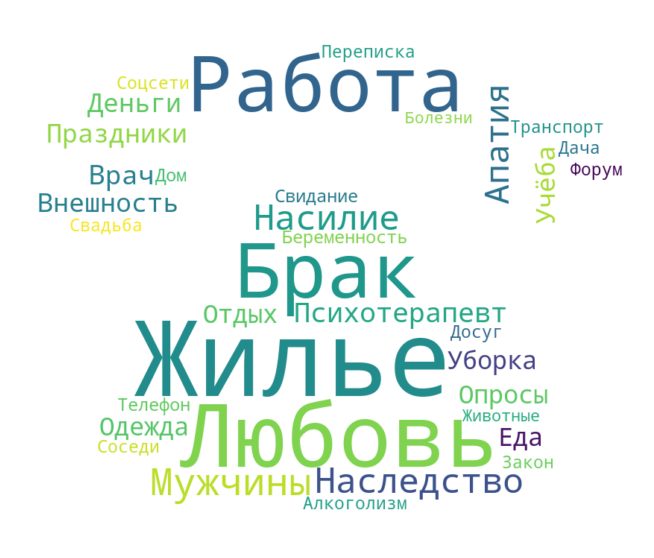

In [ ]:
topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='Final')
wordmap_df = topics_df[['First Word','Size']].groupby(['First Word'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['First Word'], wordmap_df['Size']))
Mask_Image_filename='phone2.png'
Mask_Image_full_filename=os.path.join(Images, Mask_Image_filename)
wc = topics_size_word_map(wordmap_dict, mask_image_file=Mask_Image_full_filename,  width=1600, height=1000)

In [ ]:
wc.to_file(TopicsSizeWordCloud_full_filename)

In [ ]:
reduced_topics_df=ReducedTopicsData(model,num_topics=num_reduced)

In [ ]:
model_coherence(model, data, reduced=True,num_topics=num_reduced)

0.5932295833321708

In [ ]:
reduced_topics_df

Id  ...             Name
0    0  ...          ипотека
1    1  ...        влюбиться
2    2  ...        должность
3    3  ...          замужем
4    4  ...       влюбляться
5    5  ...          умереть
6    6  ...            ссора
7    7  ...           апатия
8    8  ...    психотерапевт
9    9  ...             врач
10  10  ...            сумма
11  11  ...            класс
12  12  ...           фигура
13  13  ...               др
14  14  ...           россия
15  15  ...            салат
16  16  ...           турция
17  17  ...             пыль
18  18  ...           куртка
19  19  ...            аборт
20  20  ...      симпатичный
21  21  ...         ложиться
22  22  ...      перезвонить
23  23  ...  проводить_время
24  24  ...          свадьба
25  25  ...            сзади
26  26  ...        переписка
27  27  ...         выпивать
28  28  ...           избить
29  29  ...          соцсеть
30  30  ...           раздел
31  31  ...           грядка
32  32  ...            сосед
33  33  ...          поводок
34  34  ...      температура

[35 rows x 6 columns]

In [ ]:
SaveToExperimentLog(Experiments_file,'Final',reduced_topics_df)

In [9]:
reduced_topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=tab_adj_data)
reduced_topics_df.head()

Id  Size  ...             Name_eng First Word end
0   0  3356  ...              Housing        Housing
1   1  2236  ...  Love and Infidelity           Love
2   2  1964  ...       Job and Career            Job
3   3  1942  ...    Love and Marriage       Marriage
4   4  1933  ...                  Men            Men

[5 rows x 10 columns]

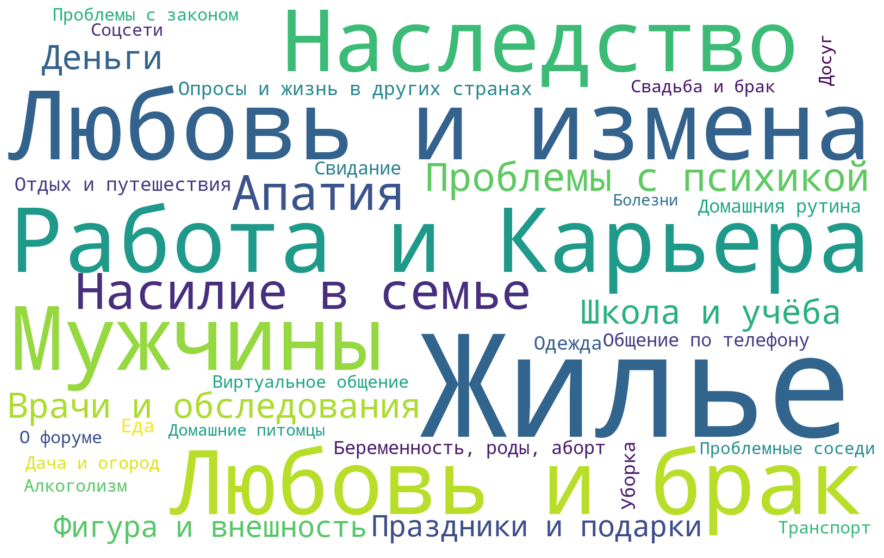

In [ ]:
wordmap_df = reduced_topics_df[['Name','Size']].groupby(['Name'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name'], wordmap_df['Size']))

wc = topics_size_word_map(wordmap_dict,   width=1600, height=1000)
#wc.to_file(TopicsSizeWordCloud_full_filename)

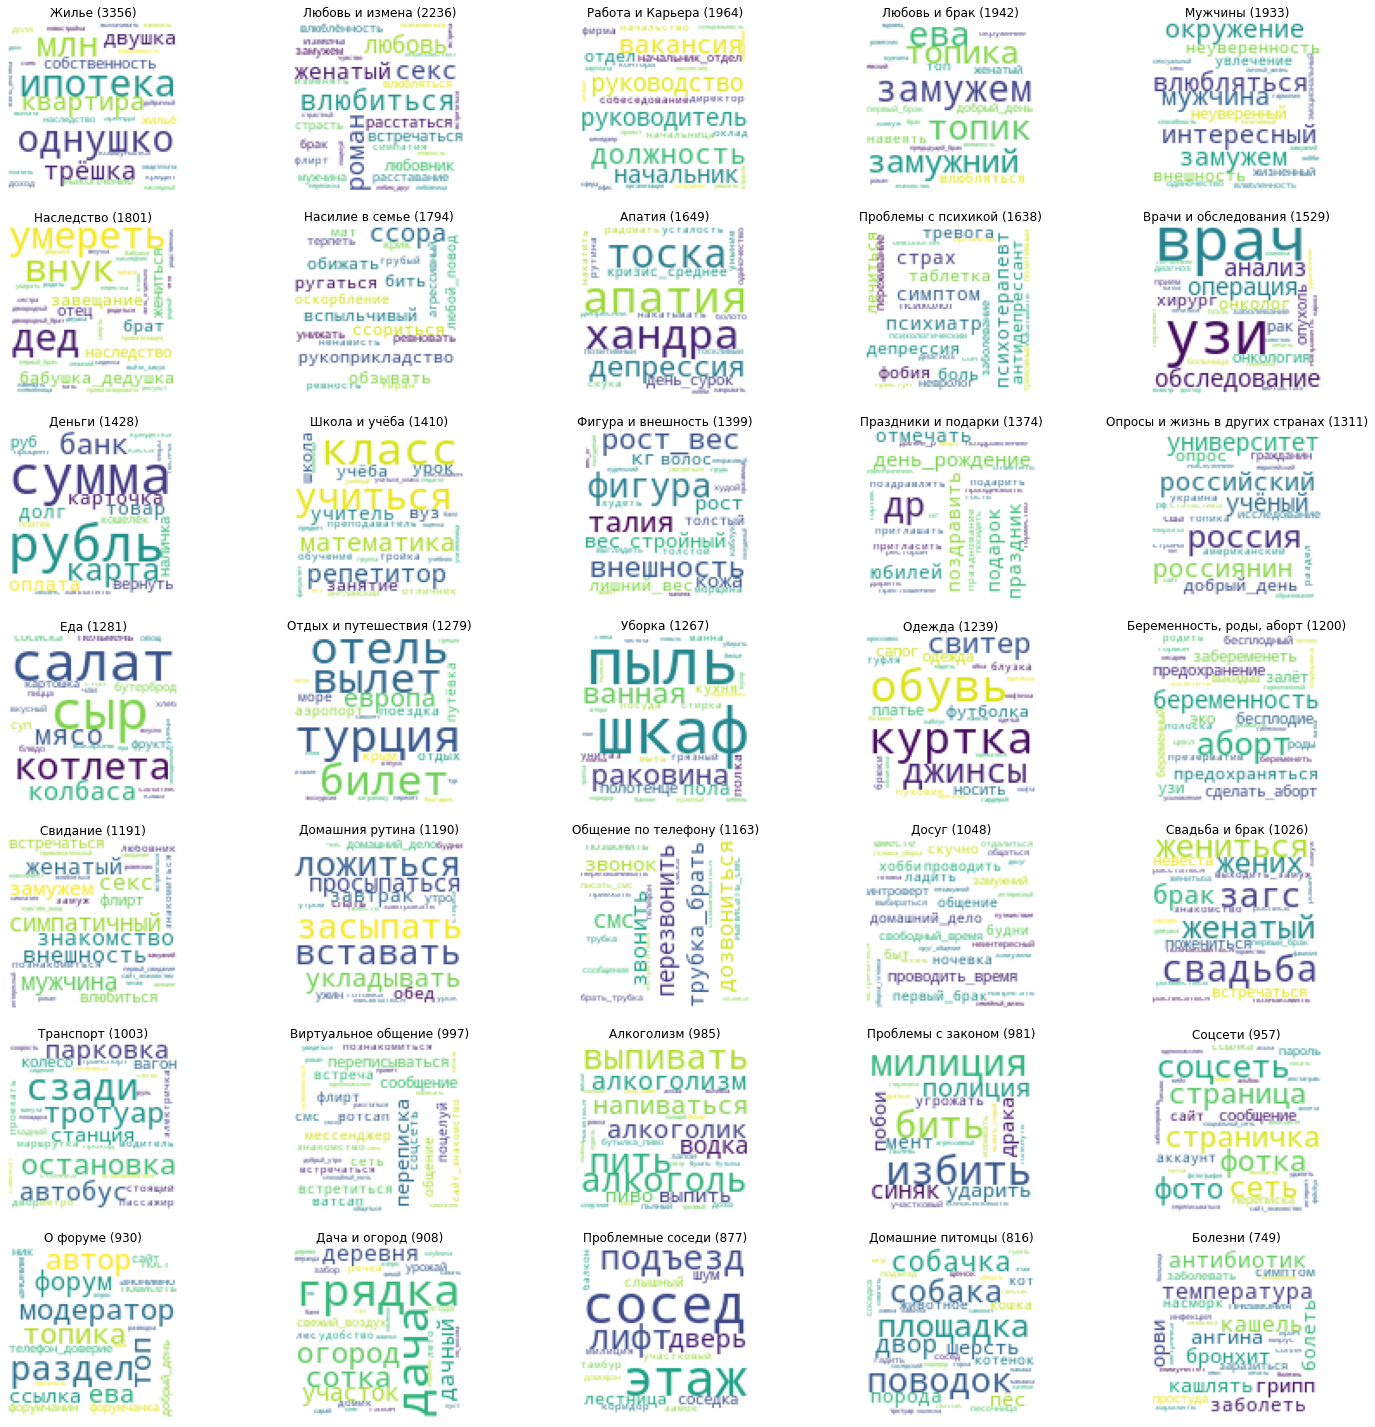

In [ ]:
fig = topics_content_word_map(model,reduced=True, nrows=7, ncols=5,  width=100, height=100, width_figsize=20, height_figsize=20, topic_names=reduced_topics_df['Name'].tolist())
fig.savefig(TopicsContentWordCloud_full_filename)

In [ ]:
topics_distance_map(model,  reduced=True,   width = 650, height = 650, topic_names=reduced_topics_df['Name'].tolist())

In [ ]:
fig=topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name'].tolist())
fig.write_html(Distancemap_full_filename)

In [ ]:
visualize_heatmap(model,n_clusters=7, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name'].tolist())

In [ ]:
fig=visualize_heatmap(model,n_clusters=3, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name'].tolist())
fig.write_html(Heatmap_full_filename)

# Translate to English

In [ ]:
!pip install transformers

In [ ]:
from transformers import FSMTForConditionalGeneration, FSMTTokenizer

In [ ]:
mname = "facebook/wmt19-ru-en"

In [ ]:
tokenizer = FSMTTokenizer.from_pretrained(mname)
translation_model = FSMTForConditionalGeneration.from_pretrained(mname)

In [ ]:
def ToEnglish(row,column):
    input = row[column]
    input_ids = tokenizer.encode(input, return_tensors="pt")
    outputs = translation_model.generate(input_ids)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
reduced_topics_df['Words_eng'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'Words'), axis=1)

In [ ]:
reduced_topics_df['Name_eng'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'Name'), axis=1)

In [ ]:
reduced_topics_df['First Word end'] = reduced_topics_df.apply(lambda x: ToEnglish(x, 'First Word'), axis=1)

In [ ]:
reduced_topics_df

Id  Size  ...                                Name_eng   First Word end
0    0  3356  ...                                 Housing          Housing
1    1  2236  ...                     Love and Infidelity             Love
2    2  1964  ...                          Job and Career             Work
3    3  1942  ...                       Love and Marriage         Marriage
4    4  1933  ...                                                         
5    5  1801  ...                             Inheritance      Inheritance
6    6  1794  ...                       Domestic violence         Violence
7    7  1649  ...                                  Apathy           Apathy
8    8  1638  ...                  Mental health problems  Psychotherapist
9    9  1529  ...                Doctors and examinations       The Doctor
10  10  1428  ...                                   Money            Money
11  11  1410  ...                        School and Study          Uchyoba
12  12  1399  ...            The Shape and the Appearance      Appearances
13  13  1374  ...                      Holidays and gifts         Holidays
14  14  1311  ...  Interviews and Life in Other Countries            Polls
15  15  1281  ...                                    Food             Food
16  16  1279  ...                         Rest and travel             Rest
17  17  1267  ...                                Cleaning         Cleaning
18  18  1239  ...                                Clothing         Clothing
19  19  1200  ...         Pregnancy, childbirth, abortion        Pregnancy
20  20  1191  ...                                  Dating           Dating
21  21  1190  ...                    The Domestic Routine             Home
22  22  1163  ...                  Communicating by phone        Telephone
23  23  1048  ...                                 Leisure          Leisure
24  24  1026  ...                    Wedding and Marriage      The Wedding
25  25  1003  ...                               Transport        Transport
26  26   997  ...                   Virtual communication   Correspondence
27  27   985  ...                              Alcoholism       Alcoholism
28  28   981  ...                   Problems with the law              Law
29  29   957  ...                            Social media     Social media
30  30   930  ...                         About the Forum            Forum
31  31   908  ...            Cottage and vegetable garden            Dacha
32  32   877  ...                      Troubled Neighbors        Neighbors
33  33   816  ...                                   Pets:          Animals
34  34   749  ...                                Diseases         Diseases

[35 rows x 10 columns]

In [ ]:
SaveToExperimentLog(Experiments_file,'Final',reduced_topics_df)

In [ ]:
reduced_topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=tab_adj_data)
reduced_topics_df.head()

Id  Size  ...             Name_eng First Word end
0   0  3356  ...              Housing        Housing
1   1  2236  ...  Love and Infidelity           Love
2   2  1964  ...       Job and Career            Job
3   3  1942  ...    Love and Marriage       Marriage
4   4  1933  ...                  Men            Men

[5 rows x 10 columns]

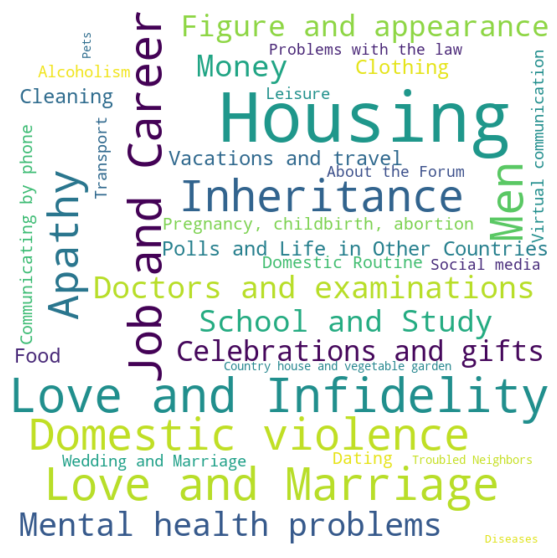

In [ ]:
wordmap_df = reduced_topics_df[['Name_eng','Size']].groupby(['Name_eng'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['Name_eng'], wordmap_df['Size']))
wc = topics_size_word_map(wordmap_dict,  width=650, height=650)
#wc.to_file(TopicsSizeWordCloud_full_filename)

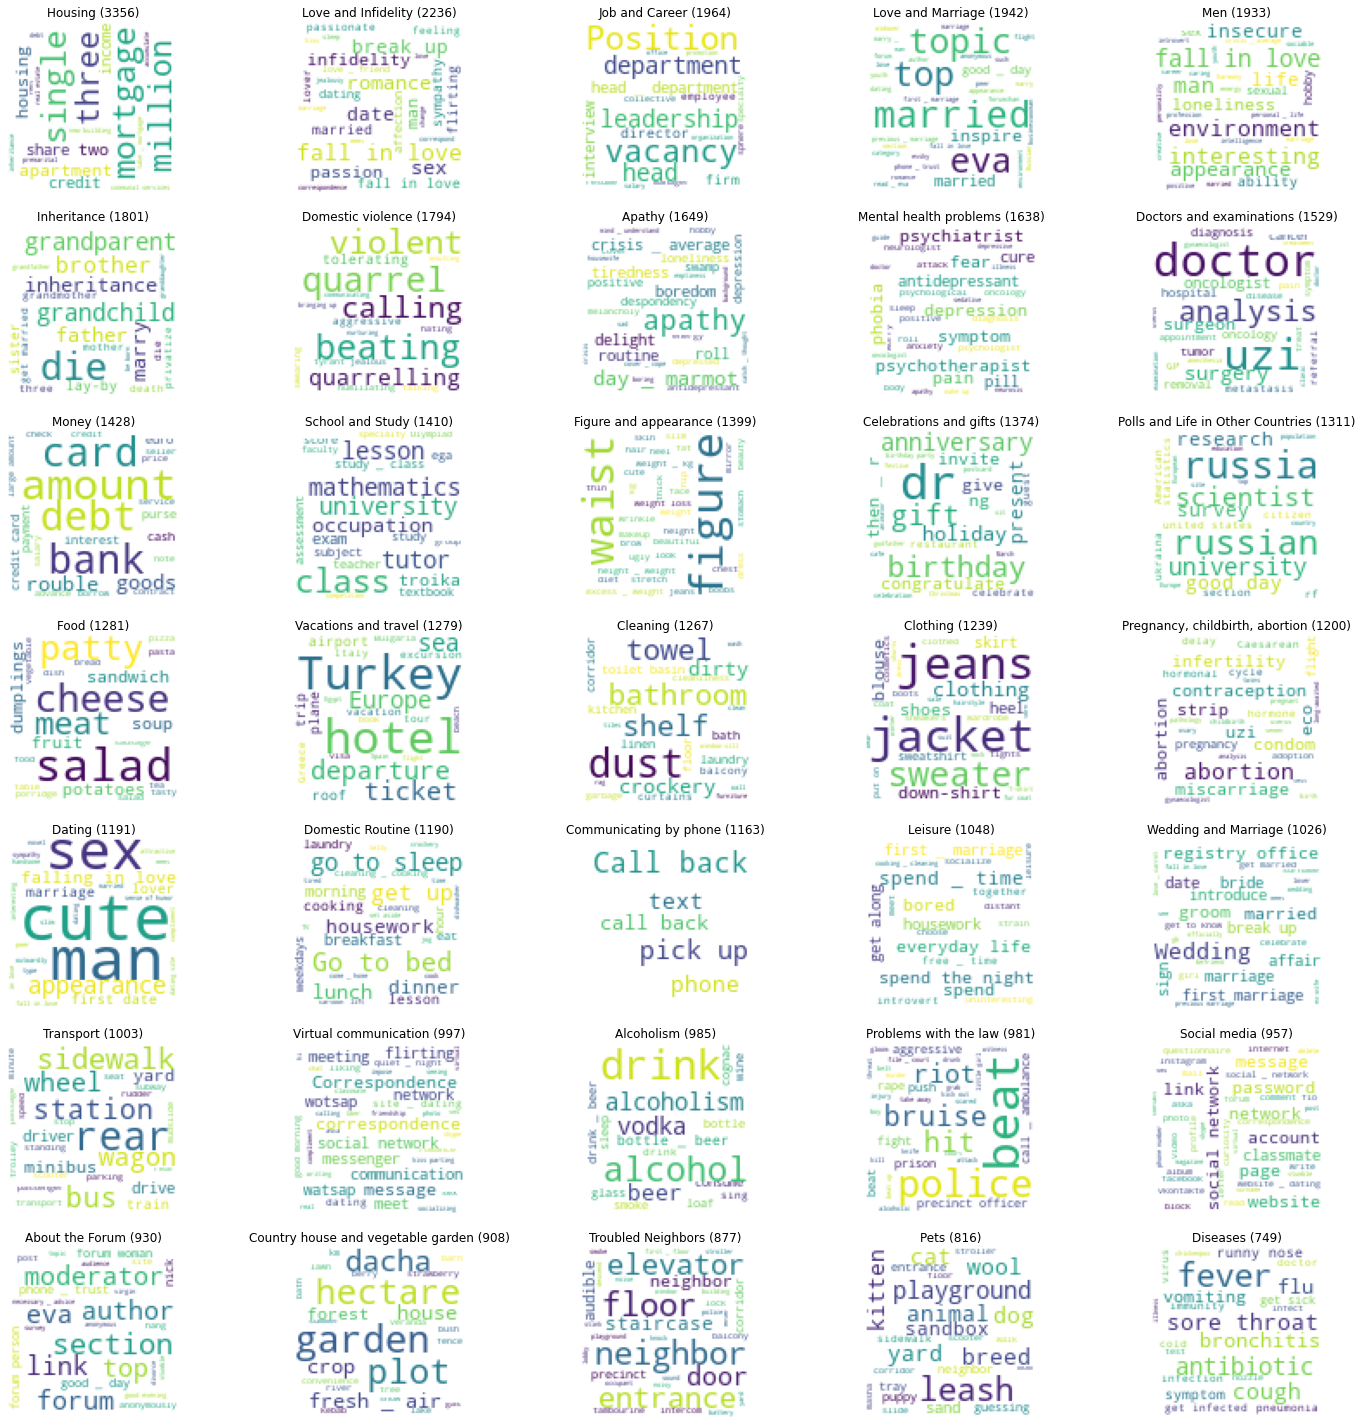

In [ ]:
topic_content=reduced_topics_df['Words_eng'].str.split(',').tolist()
fig = topics_content_word_map(model,reduced=True, nrows=7, ncols=5,  width=100, height=100, width_figsize=20, height_figsize=20,topic_content=topic_content, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.savefig(TopicsContentWordCloud_full_filename_eng)

In [ ]:
topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name_eng'].tolist())

In [ ]:
fig=topics_distance_map(model,  reduced=True,  width = 650, height = 650, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.write_html(Distancemap_full_filename_eng)

In [ ]:
visualize_heatmap(model,n_clusters=7, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name_eng'].tolist())

In [ ]:
fig=visualize_heatmap(model,n_clusters=7, reduced=True,width=800,height=800, topic_names=reduced_topics_df['Name_eng'].tolist())
fig.write_html(Heatmap_full_filename_eng)

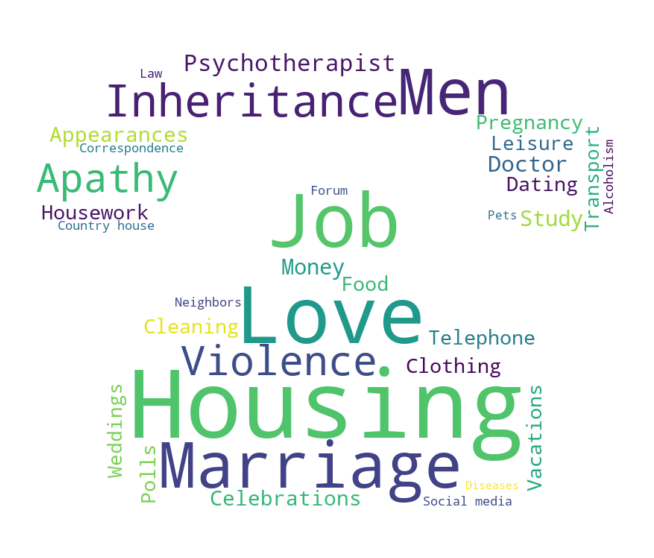

In [14]:
topics_df = pd.read_excel(open(Experiments_file, 'rb'), sheet_name='Final')
wordmap_df = topics_df[['First Word end','Size']].groupby(['First Word end'])['Size'].sum().reset_index().sort_values('Size',ascending=False)
wordmap_dict = dict(zip(wordmap_df['First Word end'], wordmap_df['Size']))
Mask_Image_filename='phone2.png'
Mask_Image_full_filename=os.path.join(Images, Mask_Image_filename)
wc = topics_size_word_map(wordmap_dict, mask_image_file=Mask_Image_full_filename,  width=1600, height=1000)

In [15]:
wc.to_file(TopicsSizeWordCloud_full_filename_eng)